In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

import glob
import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import time
from tqdm import tqdm
import copy
from IPython.display import display, Image, clear_output

import tqdm

In [2]:
from diffusers import StableDiffusionPipeline
import torch

# Load stable diffusion model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae=  pipe.vae.to(device)

def decode_latents_grad(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    latents = 1 / 0.18215 * latents

    imgs = vae.decode(latents).sample

    imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def decode_latents(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    with torch.no_grad():
        with torch.amp.autocast(device):
            latents = 1 / 0.18215 * latents

            with torch.no_grad():
                imgs = vae.decode(latents).sample

            imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def encode_imgs(imgs):
    # imgs: [B, 3, H, W]
    with torch.no_grad():
        with torch.amp.autocast(device):
            imgs = 2 * imgs - 1

            posterior = vae.encode(imgs).latent_dist
            latents = posterior.sample() * 0.18215

    return latents


import tqdm
decoded_latents = []
for i in tqdm.tqdm(range(5)):
    for j in range(i*100):
        for amp in range(1,5):
            rnd_latent = torch.randn((1,4, 2**i, 2**i), device=device)  * amp
            decoded_latent = decode_latents(rnd_latent)
            decoded_latents.append(decoded_latent.cpu())
# import pickle
# with open('./dump_for_train/decoded_latents.pickle','wb') as f:
#     pickle.dump(decoded_latents, f)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.5.1+cu121 with CUDA 1201 (you have 2.6.0+cu124)
    Python  3.12.8 (you have 3.12.2)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:59<00:00, 11.88s/it]


In [3]:
cd AdversarialRendering/

/home/dcor/niskhizov/AdversarialRendering


In [4]:
import pickle

dump_dir = './dump_for_train/'


In [5]:
with open(dump_dir + 'adv_patchs.pickle','rb') as f:
    adv_patchs = pickle.load(f)
with open(dump_dir + 'frames.pickle','rb') as f:
    frames = pickle.load(f)

In [196]:

with open(dump_dir + 'orig_ref_frame.pickle','rb') as f:
    orig_ref_frame = pickle.load(f)

with open(dump_dir + 'H.pickle','rb') as f:
    H = pickle.load(f)

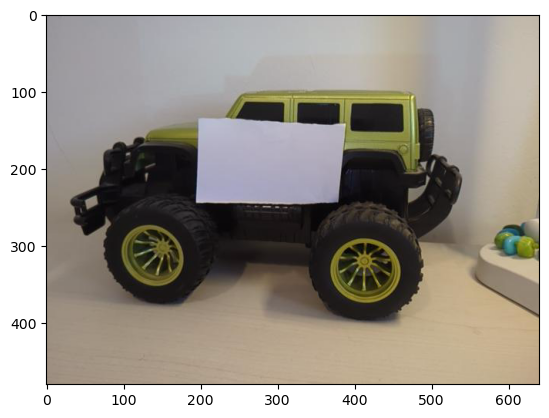

In [197]:
plt.imshow(orig_ref_frame)

In [198]:


from torchvision import transforms

tt = transforms.ToTensor()

import torch 
import kornia
H_t = torch.tensor(H).float().unsqueeze(0).cuda()
def warp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t, (orig_ref_frame.shape[0], orig_ref_frame.shape[1]))

H_t_i = H_t.inverse()
def unwarp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t_i , (300,600))


In [ ]:
# import pickle
# import datetime

# curr_without_sec = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
# curr_without_sec = curr_without_sec.replace(" ", "_")

# with open(dump_dir + f'H_t_{curr_without_sec}.pickle','wb') as f:
#     pickle.dump(H_t, f)

In [45]:
from torch import nn 
from torchvision import models
from torchvision import transforms
from PIL import Image

class LightCNN(nn.Module):
    def __init__(self):
        super(LightCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),  # 4x60x80 -> 8x60x80
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1), # 16x60x80 -> 8x60x80
            nn.LeakyReLU(),
            nn.Conv2d(8, 3, kernel_size=3, padding=1) )  # 8x60x80 -> 4x60x80
        
        # self.loss_estimator = nn.Sequential(nn.Conv2d(16, 8 ,stride=2, kernel_size=5), nn.LeakyReLU(),
        #                                      nn.Conv2d(8, 4, stride=2,kernel_size=5), nn.LeakyReLU(),
        #                                      nn.Conv2d(4, 1, stride=2,kernel_size=5), nn.LeakyReLU(),
        #                                     )
        # self.loss_final = nn.Linear(1*34*72, 1)
        # self.final_relu = nn.ReLU()


    def forward(self, x):
        x = self.encoder(x)
        # lx = self.loss_estimator(x)
        # lx = lx.view(lx.size(0), -1)
        # lx = self.final_relu(self.loss_final(lx))

        x = self.decoder(x)
        return x

In [ ]:
botorch_dir = './botorch_snapshots/'
import glob
patchs = list(glob.glob(botorch_dir + '*patch.jpg', recursive=True))
aug = [x.replace('patch.jpg', 'frame_aug.jpg') for x in patchs]


In [ ]:
unwrapped_frames = []

for frame in tqdm.tqdm(frames):
    frame_tensor = torch.tensor(frame).permute(2,0,1).float().cuda().unsqueeze(0) / 255
    unwrapped_frame = unwarp(frame_tensor).squeeze(0).cpu()
    unwrapped_frames.append(unwrapped_frame)



100%|██████████| 4000/4000 [00:16<00:00, 249.09it/s]


In [8]:
# for i in range(0,4000,100):
#     plt.imshow(unwrapped_frames[i].permute(1,2,0).numpy())
#     plt.show()
#     plt.imshow(adv_patchs[i].float().permute(1,2,0).numpy())
#     plt.show()
#     print('#######################################################')

In [36]:
ds = list(zip(patchs, aug))

In [51]:
# torch train test split
from torch.utils.data import DataLoader, random_split, Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        data = [(x[0], x[1]) for x in data if os.path.exists(x[0]) and os.path.exists(x[1])]
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        adv_patch, unwrapped_frame = self.data[idx]
        adv_patch = cv2.imread(adv_patch, cv2.IMREAD_COLOR)
        adv_patch = tt(cv2.cvtColor(adv_patch, cv2.COLOR_BGR2RGB))
        unwrapped_frame = cv2.imread(unwrapped_frame, cv2.IMREAD_COLOR)
        unwrapped_frame = tt(cv2.cvtColor(unwrapped_frame, cv2.COLOR_BGR2RGB))

        return adv_patch, unwrapped_frame
    
dataset = CustomDataset(ds)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


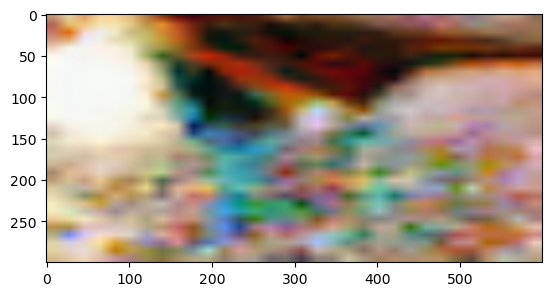

In [52]:
plt.imshow(dataset[0][0].permute(1,2,0).numpy())

In [53]:
mapper = LightCNN().cuda()#LightCNN().cuda()
mapper_opt = torch.optim.AdamW(mapper.parameters(), lr=0.001)
mapper.train()

LightCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
L1 = nn.L1Loss()
for epoch in tqdm.tqdm(range(1000)):
    train_loss = 0
    for i, (s, f) in enumerate(train_loader):
        s = s.cuda().float()
        f = f.cuda().float()
        mapper_opt.zero_grad()
        pred = mapper(s.squeeze(1))
        loss = L1(pred, f.squeeze(1))
        # lossloss = (lx - loss).pow(2).mean()
        # loss += lossloss
        loss.backward()
        mapper_opt.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

    if epoch % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for i, (s, f) in enumerate(test_loader):
                s_test = s.cuda().float()
                f_test = f.cuda().float()
                pred_test = mapper(s_test.squeeze(1))
                loss = L1(pred_test, f_test.squeeze(1))
                test_loss += loss.item()
            test_loss /= len(test_loader)
        
            print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")
        



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.1148


  0%|          | 1/1000 [01:55<31:59:33, 115.29s/it]

Epoch 1, Test Loss: 0.0947


  0%|          | 2/1000 [02:28<18:29:50, 66.72s/it] 

Epoch 2, Train Loss: 0.0874


  0%|          | 3/1000 [03:00<14:08:56, 51.09s/it]

Epoch 3, Train Loss: 0.0672


  0%|          | 4/1000 [03:32<12:04:52, 43.67s/it]

Epoch 4, Train Loss: 0.0644


  0%|          | 5/1000 [04:05<10:56:27, 39.59s/it]

Epoch 5, Train Loss: 0.0631


  1%|          | 6/1000 [04:37<10:17:07, 37.25s/it]

Epoch 6, Train Loss: 0.0623


  1%|          | 7/1000 [05:10<9:52:14, 35.78s/it] 

Epoch 7, Train Loss: 0.0603


  1%|          | 8/1000 [05:43<9:35:08, 34.79s/it]

Epoch 8, Train Loss: 0.0606


  1%|          | 9/1000 [06:16<9:24:29, 34.18s/it]

Epoch 9, Train Loss: 0.0593


  1%|          | 10/1000 [06:48<9:15:26, 33.66s/it]

Epoch 10, Train Loss: 0.0588
Epoch 11, Train Loss: 0.0590


  1%|          | 11/1000 [07:35<10:19:38, 37.59s/it]

Epoch 11, Test Loss: 0.0578


  1%|          | 12/1000 [08:10<10:09:01, 36.99s/it]

Epoch 12, Train Loss: 0.0582


  1%|▏         | 13/1000 [08:51<10:28:32, 38.21s/it]

Epoch 13, Train Loss: 0.0580


  1%|▏         | 14/1000 [09:24<10:01:47, 36.62s/it]

Epoch 14, Train Loss: 0.0576


  2%|▏         | 15/1000 [09:57<9:42:16, 35.47s/it] 

Epoch 15, Train Loss: 0.0573


  2%|▏         | 16/1000 [10:30<9:30:17, 34.77s/it]

Epoch 16, Train Loss: 0.0572


  2%|▏         | 17/1000 [11:03<9:22:39, 34.34s/it]

Epoch 17, Train Loss: 0.0565


  2%|▏         | 18/1000 [11:37<9:16:12, 33.98s/it]

Epoch 18, Train Loss: 0.0570


  2%|▏         | 19/1000 [12:10<9:10:57, 33.70s/it]

Epoch 19, Train Loss: 0.0564


  2%|▏         | 20/1000 [12:43<9:07:05, 33.50s/it]

Epoch 20, Train Loss: 0.0562
Epoch 21, Train Loss: 0.0564


  2%|▏         | 21/1000 [13:22<9:33:42, 35.16s/it]

Epoch 21, Test Loss: 0.0532


  2%|▏         | 22/1000 [13:56<9:27:21, 34.81s/it]

Epoch 22, Train Loss: 0.0556


  2%|▏         | 23/1000 [14:29<9:17:43, 34.25s/it]

Epoch 23, Train Loss: 0.0559


  2%|▏         | 24/1000 [15:01<9:09:34, 33.79s/it]

Epoch 24, Train Loss: 0.0554


  2%|▎         | 25/1000 [15:34<9:03:12, 33.43s/it]

Epoch 25, Train Loss: 0.0558


  3%|▎         | 26/1000 [16:06<8:56:17, 33.04s/it]

Epoch 26, Train Loss: 0.0553


  3%|▎         | 27/1000 [16:39<8:54:17, 32.95s/it]

Epoch 27, Train Loss: 0.0550


  3%|▎         | 28/1000 [17:19<9:26:58, 35.00s/it]

Epoch 28, Train Loss: 0.0554


  3%|▎         | 29/1000 [18:00<9:58:24, 36.98s/it]

Epoch 29, Train Loss: 0.0549


  3%|▎         | 30/1000 [18:36<9:54:25, 36.77s/it]

Epoch 30, Train Loss: 0.0556
Epoch 31, Train Loss: 0.0547


  3%|▎         | 31/1000 [19:15<10:00:14, 37.17s/it]

Epoch 31, Test Loss: 0.0530


  3%|▎         | 32/1000 [19:47<9:38:54, 35.88s/it] 

Epoch 32, Train Loss: 0.0550


  3%|▎         | 33/1000 [20:20<9:22:12, 34.88s/it]

Epoch 33, Train Loss: 0.0543


  3%|▎         | 34/1000 [20:53<9:11:49, 34.27s/it]

Epoch 34, Train Loss: 0.0547


  4%|▎         | 35/1000 [21:26<9:06:30, 33.98s/it]

Epoch 35, Train Loss: 0.0542


  4%|▎         | 36/1000 [21:59<8:59:40, 33.59s/it]

Epoch 36, Train Loss: 0.0542


  4%|▎         | 37/1000 [22:32<8:57:27, 33.49s/it]

Epoch 37, Train Loss: 0.0539


  4%|▍         | 38/1000 [23:05<8:55:22, 33.39s/it]

Epoch 38, Train Loss: 0.0541


  4%|▍         | 39/1000 [23:38<8:51:33, 33.19s/it]

Epoch 39, Train Loss: 0.0541


  4%|▍         | 40/1000 [24:11<8:48:20, 33.02s/it]

Epoch 40, Train Loss: 0.0536
Epoch 41, Train Loss: 0.0536


  4%|▍         | 41/1000 [24:50<9:16:56, 34.84s/it]

Epoch 41, Test Loss: 0.0530


  4%|▍         | 42/1000 [25:23<9:07:28, 34.29s/it]

Epoch 42, Train Loss: 0.0537


  4%|▍         | 43/1000 [25:56<9:00:25, 33.88s/it]

Epoch 43, Train Loss: 0.0536


  4%|▍         | 44/1000 [26:29<8:56:34, 33.68s/it]

Epoch 44, Train Loss: 0.0534


  4%|▍         | 45/1000 [27:09<9:27:21, 35.65s/it]

Epoch 45, Train Loss: 0.0534


  5%|▍         | 46/1000 [27:52<10:03:50, 37.98s/it]

Epoch 46, Train Loss: 0.0534


  5%|▍         | 46/1000 [28:20<9:47:50, 36.97s/it] 


KeyboardInterrupt: 

In [113]:
from torch.nn import MSELoss

In [191]:
with torch.no_grad():
    test_loss = 0
    for i, (s, f) in enumerate(test_loader):
        s_test = s.cuda().float()
        f_test = f.cuda().float()
        pred_test = mapper(s_test.squeeze(1))
        loss = (pred_test - f_test.squeeze(1)).pow(2).sum() / f_test.flatten(1).shape[1]
        test_loss += loss / test_size


In [ ]:
tds = list(test_dataset)

In [199]:
print(torch.stack([x[0] for x in tds]).std())
print(torch.stack([x[1] for x in tds]).std())
print(torch.sqrt(test_loss))

tensor(0.2800)
tensor(0.2211)
tensor(0.0851, device='cuda:0')


In [193]:
# save the model
import datetime
curr_without_sec = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
curr_without_sec = curr_without_sec.replace(" ", "_")
torch.save(mapper.state_dict(), f'./dump_for_train/mapper_{curr_without_sec}.pth')

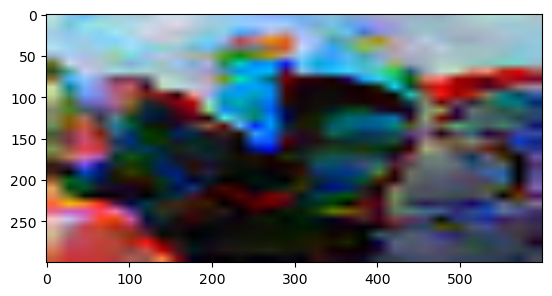

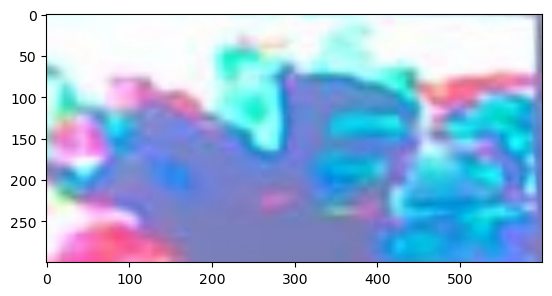

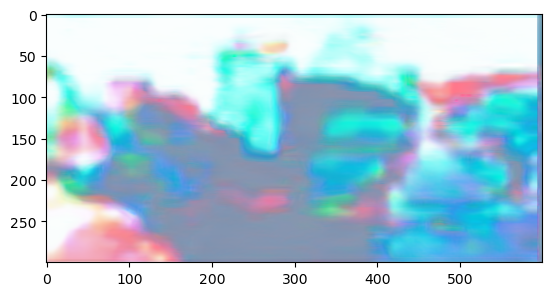

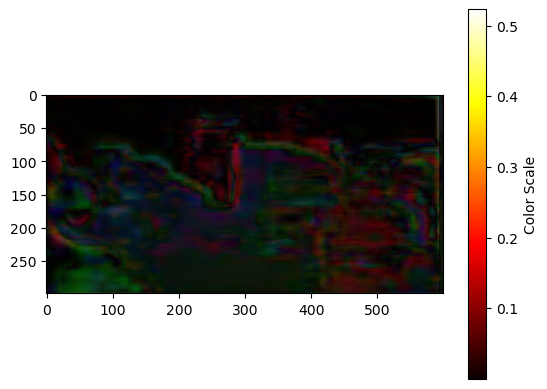

In [224]:
plt.imshow(s_test[0].detach().cpu().float().numpy().transpose(1,2,0))
plt.show()
plt.imshow(f_test[0].detach().cpu().float().numpy().transpose(1,2,0))
plt.show()
plt.imshow(pred_test[0].detach().cpu().float().numpy().transpose(1,2,0))
plt.show()
diff = pred_test[0].detach().cpu().float().numpy().transpose(1,2,0) - f_test[0].detach().cpu().float().numpy().transpose(1,2,0)
# plt.imshow(diff)
# add color scale bar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

diff = np.abs(diff)

fig, ax = plt.subplots()
cax = ax.imshow(diff, cmap='hot')
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('Color Scale')
plt.show()

In [156]:
from torch import nn 
from torchvision import models
from torchvision import transforms
from PIL import Image

class LightCNN2(nn.Module):
    def __init__(self):
        super(LightCNN2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, padding=1),  # 4x60x80 -> 8x60x80
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), # 8x60x80 -> 16x60x80
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1), # 16x60x80 -> 8x60x80
            nn.LeakyReLU(),
            nn.Conv2d(8, 4, kernel_size=3, padding=1) )  # 8x60x80 -> 4x60x80

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [157]:
import torchvision
de_resizer = torchvision.transforms.Resize((32,32))
resizer = torchvision.transforms.Resize((300,600))

In [158]:
mapper_latent = LightCNN2().cuda()#LightCNN().cuda()
mapper_latent_opt = torch.optim.AdamW(mapper_latent.parameters(), lr=0.001)

In [164]:
L1 = nn.L1Loss()
for epoch in tqdm.tqdm(range(1000)):
    train_loss = 0
    for i, (s, f) in enumerate(train_loader):
        s = s.cuda().float()
        f = f.cuda().float()
        
        s = encode_imgs(de_resizer(s))
        f = encode_imgs(de_resizer(f))

        mapper_latent_opt.zero_grad()
        pred = mapper_latent(s.squeeze(1))
        loss = L1(pred, f.squeeze(1))
        # lossloss = (lx - loss).pow(2).mean()
        # loss += lossloss
        loss.backward()
        mapper_latent_opt.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

    if epoch % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for i, (s, f) in enumerate(test_loader):
                s_test = s.cuda().float()
                f_test = f.cuda().float()

                s_test = encode_imgs(de_resizer(s_test))
                f_test = encode_imgs(de_resizer(f_test))


                pred_test = mapper_latent(s_test.squeeze(1))
                loss = L1(pred_test, f_test.squeeze(1))
                test_loss += loss.item()
            test_loss /= len(test_loader)
        
            print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")
        



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.2305


  0%|          | 1/1000 [00:37<10:22:13, 37.37s/it]

Epoch 1, Test Loss: 0.2781


  0%|          | 1/1000 [00:43<12:00:07, 43.25s/it]


KeyboardInterrupt: 

In [188]:
with torch.no_grad():
    test_loss = 0
    for i, (s, f) in enumerate(test_loader):
        s_test = s.cuda().float()
        f_test = f.cuda().float()

        s_test = encode_imgs(de_resizer(s_test))
        f_test = encode_imgs(de_resizer(f_test))

        pred_test = mapper_latent(s_test.squeeze(1))
        loss = (resizer(decode_latents(pred_test).float()) - resizer(decode_latents(f_test).float())).pow(2).sum() / f_test.flatten(1).shape[1]
        test_loss += loss / test_size


In [189]:
print(torch.stack([x[0] for x in tds]).std())
print(torch.stack([x[1] for x in tds]).std())
print(torch.sqrt(test_loss))

tensor(0.2800)
tensor(0.2211)
tensor(10.3534, device='cuda:0')


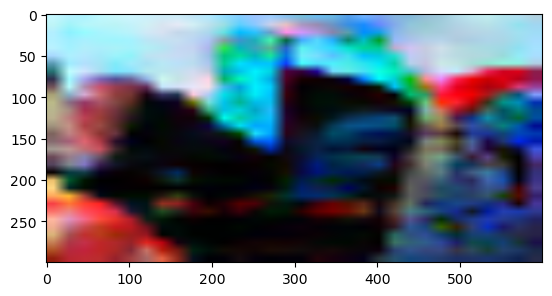

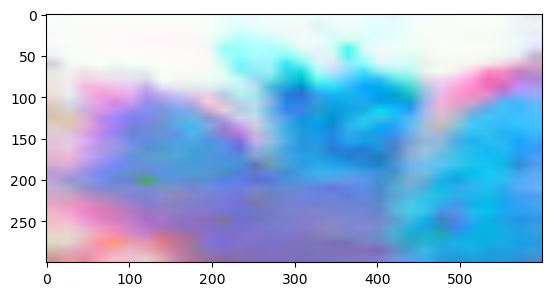

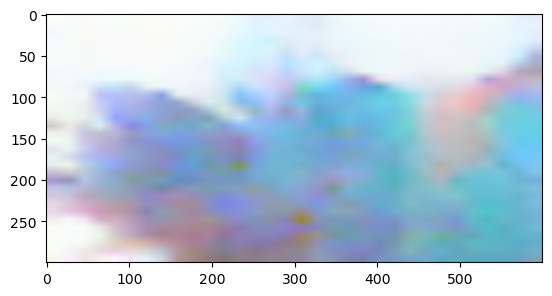

In [190]:
idx = 0
plt.imshow(resizer(decode_latents(s_test[idx].unsqueeze(0)).float()).squeeze(0).permute(1,2,0).cpu().numpy())
plt.show()
plt.imshow(resizer(decode_latents(f_test[idx].unsqueeze(0)).float()).squeeze(0).permute(1,2,0).cpu().numpy())
plt.show()
plt.imshow(resizer(decode_latents(pred_test[idx].unsqueeze(0)).float()).squeeze(0).permute(1,2,0).cpu().numpy())
plt.show()



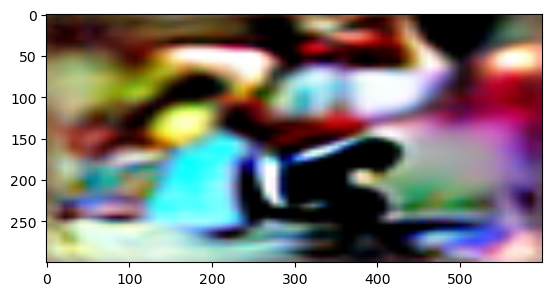

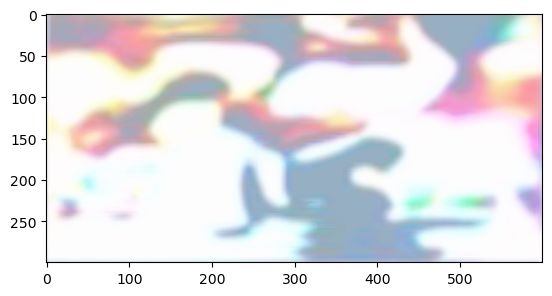

In [47]:
rnd_latent = torch.randn((1,4, 8, 8), device=device) 
decoded_latent = resizer(decode_latents(rnd_latent)) 
pred_test = mapper(decoded_latent.float())
plt.imshow(decoded_latent[0].detach().cpu().float().numpy().transpose(1,2,0))
plt.show()
plt.imshow(pred_test[0].detach().cpu().float().numpy().transpose(1,2,0))    
plt.show()


In [252]:
import torchvision
device = 'cuda'
latent = (torch.rand((1,4, 4, 4), device=device) - 0.5) * 2
latent.requires_grad = True

resizer = torchvision.transforms.Resize((300, 600))

# latent = torch.rand((1,3, 10, 20), device=device) / 2
# latent.requires_grad = True

lbfgs_latent_opt = torch.optim.LBFGS([latent], lr=0.01, max_iter=10)
# latent_opt = torch.optim.Adam([latent], lr=0.001)

In [203]:
import sys
sys.path.insert(0, '/home/dcor/niskhizov//AdversarialRendering/utils')
from classfier import *

In [77]:
mapper.load_state_dict(torch.load(f'./dump_for_train/mapper_2025-04-05_14:38.pth'))

<All keys matched successfully>

In [200]:
ref_tensor = torch.tensor(orig_ref_frame).permute(2,0,1).float().cuda() / 255
# ref_tensor = frame_tensor

In [79]:


def latent_closure_adp():
    # with torch.amp.autocast(device):
    lbfgs_latent_opt.zero_grad()

    # latent_normalized = latent - latent.mean()
    # latent_normalized = latent_normalized / latent_normalized.std()

    d = decode_latents_grad(latent).float()

    adv_patch = resizer(d)

    adv_patch = mapper(adv_patch)

    w_mask  =warp(adv_patch*0+1)
    w  =warp(adv_patch)

    sum_tensor =  ((w_mask != 0) * -1 + 1) * ref_tensor + w * 1#((w_mask != 0) * -0.5 + 1) * ref_tensor + w * 0.5

    sum_tensor = sum_tensor #+ torch.randn_like(sum_tensor.cuda()) * 0.1

    adv_loss = adv_loss_calc(sum_tensor) #+ adv_patch.norm() / 10000

    adv_loss.backward()

    return adv_loss

In [253]:
latent_opt = torch.optim.Adam([latent], lr=0.1)

In [254]:
import torchvision.transforms as T

jitter = T.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5)

/tmp/ipykernel_2921402/1928546528.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(10000)):


  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 0, Loss: 0.0092. grad_norm: 0.0083


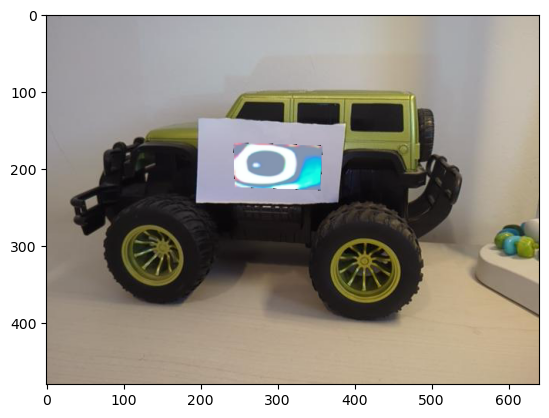

iPod: 0.114%


Iteration 100, Loss: 0.0090. grad_norm: 0.0054


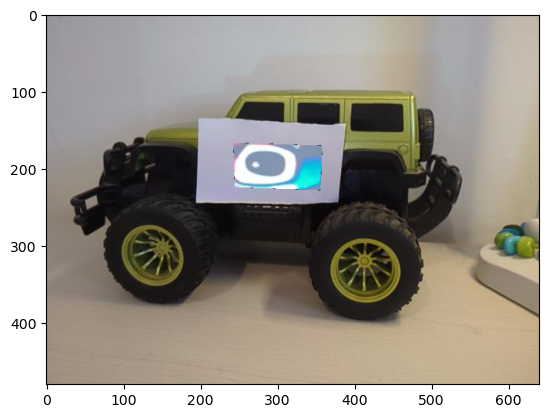

iPod: 0.110%


Iteration 200, Loss: 0.0066. grad_norm: 0.0056


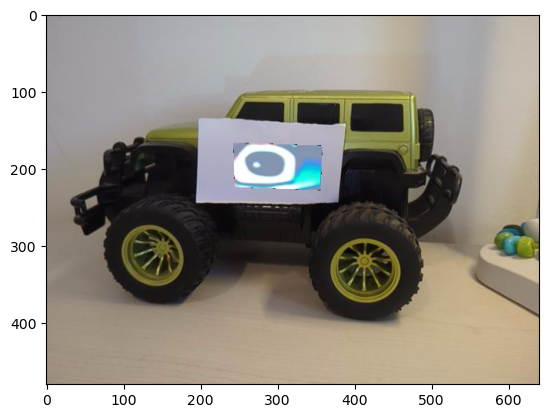

iPod: 0.109%


Iteration 300, Loss: 0.0095. grad_norm: 0.0064


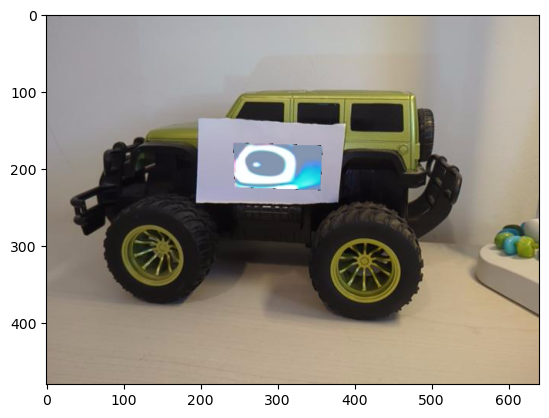

iPod: 0.110%


KeyboardInterrupt: 

In [256]:
for i in tqdm.tqdm_notebook(range(10000)):
    # adv_loss = lbfgs_latent_opt.step(latent_closure_adp)
    latent_opt.zero_grad()
    d = decode_latents_grad(latent).float()

    adv_patch = resizer(d)

    adv_patch_m = jitter(mapper(adv_patch))

    w_mask  =warp(adv_patch_m*0+1)
    w  =warp(adv_patch_m)

    sum_tensor =  ((w_mask != 0) * -0.5 + 1) * ref_tensor + w * 0.5

    adv_loss = adv_loss_calc(sum_tensor) #+ adv_patch.norm() / 10000
    
    adv_loss.backward()

    latent_opt.step()

    if i % 100 == 0:
        # print(f"Iteration {i}, Loss: {latent_closure_adp().item():.4f}")
        print(f"Iteration {i}, Loss: {adv_loss.item():.4f}. grad_norm: {latent.grad.norm().item():.4f}")

        with torch.no_grad():
            d = decode_latents(latent).float()
            adv_patch = resizer(d)
            adv_patch_m = mapper(adv_patch)

            w_mask  =warp(adv_patch_m*0+1)
            w  =warp(adv_patch_m)

            sum_tensor =  ((w_mask != 0) * -1 + 1) * ref_tensor + w * 1##((w_mask != 0) * -0.5 + 1) * ref_tensor + w * 0.5
            sum_tensor = sum_tensor.cpu()

            plt.imshow(sum_tensor[0].permute(1,2,0).numpy())

            plt.show()
            print(resnet_predict(sum_tensor.cuda()))
            # print(lx)

In [251]:
# save latent
import datetime
curr_without_sec = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
curr_without_sec = curr_without_sec.replace(" ", "_")
torch.save(latent.detach(), f'./dump_for_train/working_latent_{curr_without_sec}.pth')


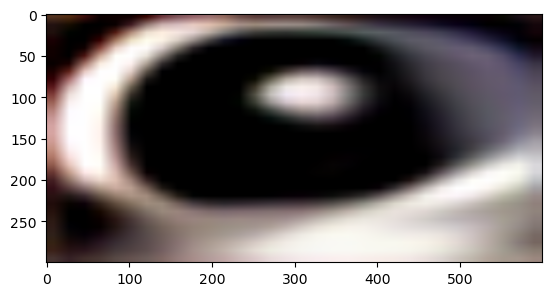

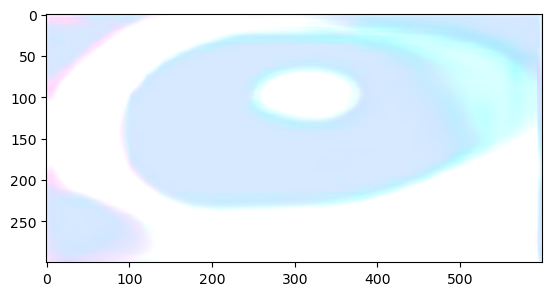

In [247]:
plt.imshow(adv_patch[0].cpu().detach().permute(1,2,0).numpy())
plt.show()
plt.imshow(adv_patch_m[0].cpu().detach().permute(1,2,0).numpy())
plt.show()

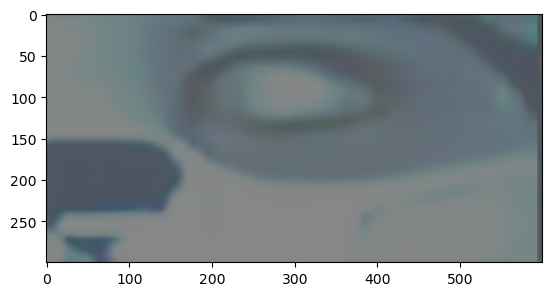

In [243]:
plt.imshow(jitter(adv_patch_m)[0].cpu().detach().permute(1,2,0).numpy())

In [225]:
inp = sum_tensor.cuda()+torch.randn_like(sum_tensor.cuda()) * 0.01

resnet_predict(inp)


'iPod: 0.114%'

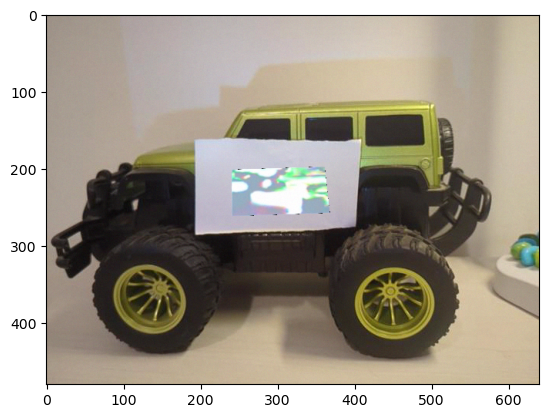

In [ ]:
plt.imshow(inp[0].detach().cpu().permute(1,2,0).numpy())

In [99]:
# load patches/frame.png
frame = cv2.imread('./patches/frame.png')
frame_tensor = torch.tensor(frame).permute(2,0,1).float().cuda() / 255

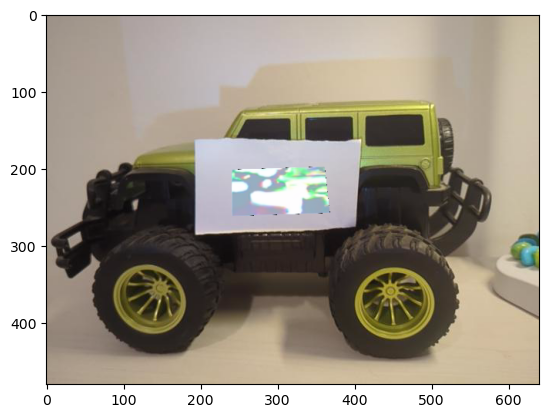

thresher: 0.110%


In [55]:

with torch.no_grad():
    d = decode_latents(latent).float()
    adv_patch = resizer(d)
    adv_patch_m = mapper(adv_patch)

    w_mask  =warp(adv_patch_m*0+1)
    w  =warp(adv_patch_m)

    sum_tensor =  ((w_mask != 0) * -1 + 1) * ref_tensor + w * 1##((w_mask != 0) * -0.5 + 1) * ref_tensor + w * 0.5
    sum_tensor = sum_tensor.cpu()

    plt.imshow(sum_tensor[0].permute(1,2,0).numpy())

    plt.show()
    print(resnet_predict(sum_tensor.cuda()))
    # print(lx)

In [105]:
with torch.no_grad():
    adv_patch_m = mapper(adv_patch)
w_mask  =warp(adv_patch_m*0+1)
w  =warp(adv_patch_m)
sum_tensor =  ((w_mask != 0) * -1 + 1) * frame_tensor + w * 1

In [108]:
resnet_predict(sum_tensor.cuda())

'half track: 0.119%'

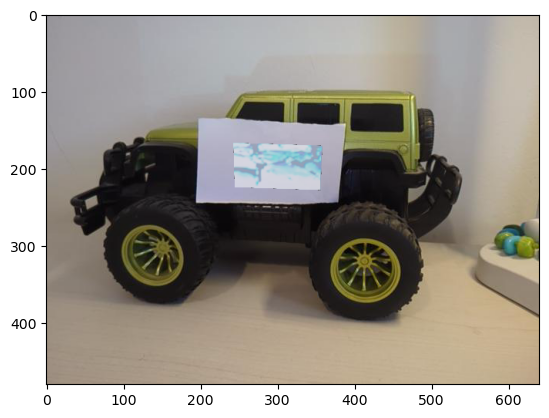

In [206]:
plt.imshow(sum_tensor[0].detach().permute(1,2,0).cpu().numpy())

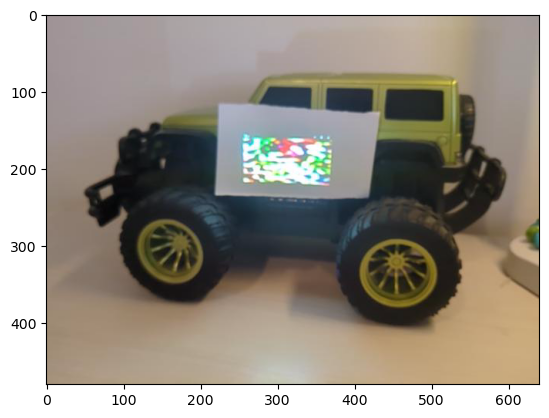

In [107]:
plt.imshow(frame)

In [90]:
print(resnet_predict(inp))

thresher: 0.105%


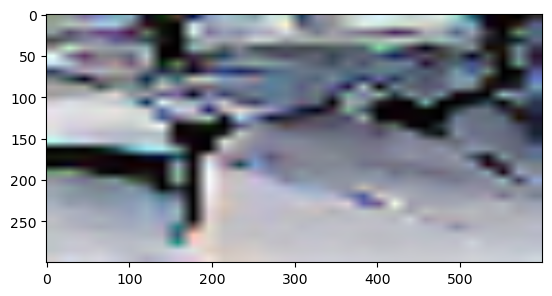

In [207]:
plt.imshow(adv_patch[0].detach().cpu().permute(1,2,0).numpy())

In [ ]:
resizer = torchvision.transforms.Resize((300, 600))

In [ ]:
a = resizer(torch.randn(1,3,10,10))

In [ ]:
mapper(a.cuda())[1]

In [ ]:
plt.imshow(a[0].permute(1,2,0).numpy())

In [ ]:
mapper(adv_patch*0+1)[1]

In [248]:
cv2.imwrite('./patches/out_18_4_2.png', (adv_patch[0].detach().cpu().permute(1,2,0).numpy()*255).astype(np.uint8))

True

In [249]:
cv2.imwrite('./patches/out_18_4_m_2.png', (adv_patch_m[0].clamp(0,1).detach().cpu().permute(1,2,0).numpy()*255).astype(np.uint8))

True

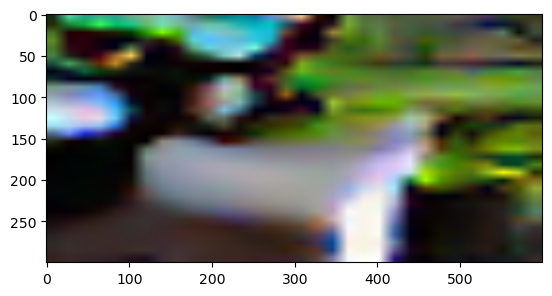

In [66]:
plt.imshow(adv_patch[0].detach().cpu().permute(1,2,0).numpy())

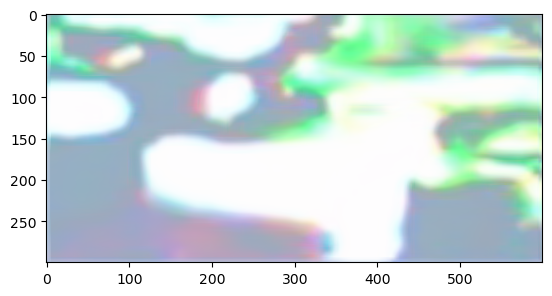

In [63]:
plt.imshow(adv_patch_m[0].detach().cpu().permute(1,2,0).numpy())

In [ ]:
import cv2

In [ ]:
cv2.imshow('sum_tensor', sum_tensor[0].permute(1,2,0).numpy() * 255)

In [ ]:
plt.imshow(adv_patch[0].permute(1,2,0).cpu().numpy())

In [ ]:
plt.imshow(adv_patch_m[0].permute(1,2,0).cpu().numpy())

In [ ]:
plt.imshow(adv_patch_m[0].permute(1,2,0).cpu().numpy())